# Code for calculating the dependence of the mean firing rate and coefficient of variation of the interspike intervals of the Brunel network on the synaptic strength J:

The following is a piece of code that uses the brian2 library to run the Brunel network for various values of J ranging from 0.01 to 0.06. We do not go beyond these values since significant correlations start to appear and the theory breaks down. The simulations are run for a total of 1000 ms for each J value.

**NOTE: THIS RETURNS THE STANDARD DEVIATION OF THE FIRING RATE NOT THAT OF THE INTERSPIKE INTERVALS**

In [ ]:
import random
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np


def sim(g, nu_ext_over_nu_thr, sim_time, ax_spikes, ax_rates, rate_tick_step, J):
    """
    g -- relative inhibitory to excitatory synaptic strength
    nu_ext_over_nu_thr -- ratio of external stimulus rate to threshold rate
    sim_time -- simulation time
    ax_spikes -- matplotlib axes to plot spikes on
    ax_rates -- matplotlib axes to plot rates on
    rate_tick_step -- step size for rate axis ticks
    """

    # network parameters
    N_E = 10000
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.005
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 20 * ms
    theta = 20 * mV
    V_r = 10 * mV
    tau_rp = 2 * ms

    # synapse parameters
    D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    defaultclock.dt = 0.1 * ms

    neurons = NeuronGroup(N,
                          """
                          dv/dt = -v/tau : volt (unless refractory)
                          """,
                          threshold="v > theta",
                          reset="v = V_r",
                          refractory=tau_rp,
                          method="exact",
    )

    excitatory_neurons = neurons[:N_E]
    inhibitory_neurons = neurons[N_E:]

    exc_synapses = Synapses(excitatory_neurons, target=neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(p=epsilon)

    inhib_synapses = Synapses(inhibitory_neurons, target=neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(p=epsilon)

    nu_ext = nu_ext_over_nu_thr * nu_thr

    external_poisson_input = PoissonInput(
        target=neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J
    )

    rate_monitor = PopulationRateMonitor(neurons)
    
    run(sim_time, report='text')
    
    return np.mean(rate_monitor.rate/Hz),np.std(rate_monitor.rate/Hz)
        
    
parameters = {
    "C": {
        "g": 5,
        "nu_ext_over_nu_thr": 2,
        "t_range": [1000, 500],
        "rate_range": [0, 200],
        "rate_tick_step": 50,
    },

}

Js = np.arange(0.01,0.6,0.01)*mV
means = np.zeros(Js.size)
stds = np.zeros(Js.size)

for i,j in enumerate(Js):
    print(i)
    print("J value: " + str(j))
    means[i],stds[i] = sim(params["g"],params["nu_ext_over_nu_thr"],1000* ms,ax_spikes,ax_rates,params["rate_tick_step"],j)

plt.scatter(Js,means)
plt.scatter(Js,stds)


## The interspike intervals:

The following piece of code averages out the mean and standard deviation of the interspike intervals of the first 50 excitatory neurons in the Brunel network. Each simulation is run for 1000 ms. The values of J chosen are the same as the ones chosen above.

In [24]:
import random
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np


def sim(g, nu_ext_over_nu_thr, sim_time, ax_spikes, ax_rates, rate_tick_step, J):
    """
    g -- relative inhibitory to excitatory synaptic strength
    nu_ext_over_nu_thr -- ratio of external stimulus rate to threshold rate
    sim_time -- simulation time
    ax_spikes -- matplotlib axes to plot spikes on
    ax_rates -- matplotlib axes to plot rates on
    rate_tick_step -- step size for rate axis ticks
    """

    # network parameters
    N_E = 10000
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.005
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 20 * ms
    theta = 20 * mV
    V_r = 10 * mV
    tau_rp = 2 * ms

    # synapse parameters
    D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    defaultclock.dt = 0.1 * ms

    neurons = NeuronGroup(N,
                          """
                          dv/dt = -v/tau : volt (unless refractory)
                          """,
                          threshold="v > theta",
                          reset="v = V_r",
                          refractory=tau_rp,
                          method="exact",
    )

    excitatory_neurons = neurons[:N_E]
    inhibitory_neurons = neurons[N_E:]

    exc_synapses = Synapses(excitatory_neurons, target=neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(p=epsilon)

    inhib_synapses = Synapses(inhibitory_neurons, target=neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(p=epsilon)

    nu_ext = nu_ext_over_nu_thr * nu_thr

    external_poisson_input = PoissonInput(
        target=neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J
    )

    spike_monitor = SpikeMonitor(neurons[:50])
    
    run(sim_time, report='text')
    
    trains = spike_monitor.spike_trains()
    stdarray = np.zeros(50)
    meanarray = np.zeros(50)
    for i in range(50):
        if trains[i].size == 0:
            stdarray[i] = 0
            meanarray[i] = 0
        else:
            stdarray[i] = np.std(np.diff(trains[i]))
            meanarray[i] = np.mean(np.diff(trains[i]))
    
    return np.mean(stdarray),np.mean(meanarray)
        
    
parameters = {
    "C": {
        "g": 5,
        "nu_ext_over_nu_thr": 2,
        "t_range": [1000, 500],
        "rate_range": [0, 200],
        "rate_tick_step": 50,
    },

}

Js = np.arange(0.01,0.6,0.01)*mV
intervalstds = np.zeros(Js.size)
intervalmeans = np.zeros(Js.size)

for i,j in enumerate(Js):
    print(i)
    print("J value: " + str(j))
    intervalstds[i],intervalmeans[i] = sim(params["g"],params["nu_ext_over_nu_thr"],1000* ms,ax_spikes,ax_rates,params["rate_tick_step"],j)
    print(intervalstds)
    print(intervalmeans)

0
J value: 10. uV
Starting simulation at t=0. s for a duration of 1. s
0.8154 s (81%) simulated in 10s, estimated 2s remaining.
1. s (100%) simulated in 12s
[0.0002527 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]
[0.01014993 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0. 

Starting simulation at t=0. s for a duration of 1. s
0.684 s (68%) simulated in 10s, estimated 5s remaining.
1. s (100%) simulated in 14s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        

1. s (100%) simulated in 14s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.00087128 0.0009375  0.00101684 0.00097162
 0.00102603 0.0011097  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.00946986 0.00949708 0.00952039 0.00916183
 0.00923676 0.00920993 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

1. s (100%) simulated in 14s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.00087128 0.0009375  0.00101684 0.00097162
 0.00102603 0.0011097  0.00110542 0.00111404 0.00126946 0.0013096
 0.00132469 0.0011697  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.00946986 0.00949708 0.00952039 0.00916183
 0.00923676 0.00920993 0.0090022  0.00878241 0.00931857 0.00918745
 0.00901678 0.00836976 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.     

Starting simulation at t=0. s for a duration of 1. s
0.5448 s (54%) simulated in 10s, estimated 8s remaining.
1. s (100%) simulated in 18s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.00087128 0.0009375  0.00101684 0.00097162
 0.00102603 0.0011097  0.00110542 0.00111404 0.00126946 0.0013096
 0.00132469 0.0011697  0.00141148 0.00137365 0.00138122 0.00139426
 0.00150265 0.00186368 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.00946986 0.00949708 0.00952039 0.00916183
 0.00923676 0.00920993 0.0090022  0.00878241 0.00931857 0.00918745
 0.00901678 0.00836976 0.00903923 0.00875

Starting simulation at t=0. s for a duration of 1. s
0.6776 s (67%) simulated in 10s, estimated 5s remaining.
1. s (100%) simulated in 14s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.00087128 0.0009375  0.00101684 0.00097162
 0.00102603 0.0011097  0.00110542 0.00111404 0.00126946 0.0013096
 0.00132469 0.0011697  0.00141148 0.00137365 0.00138122 0.00139426
 0.00150265 0.00186368 0.00140723 0.00169538 0.00164111 0.00167923
 0.00190649 0.00217877 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.00946986 0.00949708 0.00952039 0.00916183
 0.00923676 0.00920993 0.0090022  0.00878241 0.00931857 0.00918745
 0.00901678 0.00836976 0.00903923

Starting simulation at t=0. s for a duration of 1. s
0.6803 s (68%) simulated in 10s, estimated 5s remaining.
1. s (100%) simulated in 14s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.00087128 0.0009375  0.00101684 0.00097162
 0.00102603 0.0011097  0.00110542 0.00111404 0.00126946 0.0013096
 0.00132469 0.0011697  0.00141148 0.00137365 0.00138122 0.00139426
 0.00150265 0.00186368 0.00140723 0.00169538 0.00164111 0.00167923
 0.00190649 0.00217877 0.00166394 0.00171113 0.0019832  0.00160053
 0.00144309 0.00234604 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.00946986 0.00949708 0.00952039 0.00916183
 0.00923676 0.00920993 0.0090022  0.00878241 0.00931857 0.00918745
 0.00901678 0.00836976 0.

Starting simulation at t=0. s for a duration of 1. s
0.6521 s (65%) simulated in 10s, estimated 5s remaining.
1. s (100%) simulated in 15s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.00087128 0.0009375  0.00101684 0.00097162
 0.00102603 0.0011097  0.00110542 0.00111404 0.00126946 0.0013096
 0.00132469 0.0011697  0.00141148 0.00137365 0.00138122 0.00139426
 0.00150265 0.00186368 0.00140723 0.00169538 0.00164111 0.00167923
 0.00190649 0.00217877 0.00166394 0.00171113 0.0019832  0.00160053
 0.00144309 0.00234604 0.00314491        nan 0.00152452 0.00178675
 0.00649058 0.00193434 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.00946986 0.00949708 0.00952039 0.00916183
 0.00923676 0.00920993 0.0090022  0.00878241 0.00931857 0.00918745
 0.00901678 0.008

Starting simulation at t=0. s for a duration of 1. s
0.6523 s (65%) simulated in 10s, estimated 5s remaining.
1. s (100%) simulated in 15s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.00087128 0.0009375  0.00101684 0.00097162
 0.00102603 0.0011097  0.00110542 0.00111404 0.00126946 0.0013096
 0.00132469 0.0011697  0.00141148 0.00137365 0.00138122 0.00139426
 0.00150265 0.00186368 0.00140723 0.00169538 0.00164111 0.00167923
 0.00190649 0.00217877 0.00166394 0.00171113 0.0019832  0.00160053
 0.00144309 0.00234604 0.00314491        nan 0.00152452 0.00178675
 0.00649058 0.00193434 0.00358367 0.00163844 0.00184682 0.00412391
 0.00194754 0.00498235 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.00946986 0.00949708 0.00952039 0.00916183
 0.00923676 0.00920993 0.0090022  0.00878241 0.00931857 0.00918745
 0.009016

Starting simulation at t=0. s for a duration of 1. s
0.6362 s (63%) simulated in 10s, estimated 6s remaining.
1. s (100%) simulated in 15s
[0.0002527  0.00041172 0.00052208 0.00060528 0.0006754  0.00074918
 0.00079393 0.00085583 0.00087128 0.0009375  0.00101684 0.00097162
 0.00102603 0.0011097  0.00110542 0.00111404 0.00126946 0.0013096
 0.00132469 0.0011697  0.00141148 0.00137365 0.00138122 0.00139426
 0.00150265 0.00186368 0.00140723 0.00169538 0.00164111 0.00167923
 0.00190649 0.00217877 0.00166394 0.00171113 0.0019832  0.00160053
 0.00144309 0.00234604 0.00314491        nan 0.00152452 0.00178675
 0.00649058 0.00193434 0.00358367 0.00163844 0.00184682 0.00412391
 0.00194754 0.00498235 0.00192371 0.00285019 0.00265652 0.00302917
        nan        nan 0.         0.         0.        ]
[0.01014993 0.01009037 0.00999258 0.00981421 0.00985244 0.00987059
 0.00964501 0.00965581 0.00946986 0.00949708 0.00952039 0.00916183
 0.00923676 0.00920993 0.0090022  0.00878241 0.00931857 0.00918745
 

In [25]:
intervalcvs = intervalstds/intervalmeans
intervalcvs.size

59

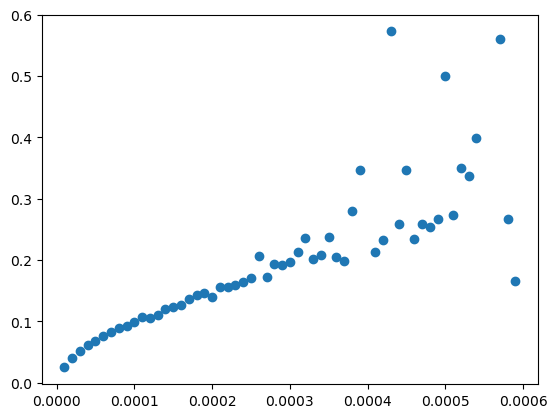

In [30]:
plt.scatter(Js,intervalcvs)

np.savetxt("intervalcvs",intervalcvs)